In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch

In [ ]:
df_mapping_locs, _ = cdu.load_names_unique_locs()
df_mapping_locs.head()

,tuple_coords,footprintWKT,count,name_loc
0,"(-2.165105, 50.956811)","POLYGON((-2.17221 50.9523,-2.17221 50.96132,-2...",53410,UKBMS_loc-0000
1,"(-2.646667, 50.775285)","POLYGON((-2.6537 50.77075,-2.6537 50.77982,-2....",51809,UKBMS_loc-0001
2,"(-0.828484, 50.888106)","POLYGON((-0.8357 50.88368,-0.8357 50.89253,-0....",48596,UKBMS_loc-0002
3,"(-1.966038, 50.59722)","POLYGON((-1.97311 50.59273,-1.97311 50.60171,-...",46522,UKBMS_loc-0003
4,"(-0.22994099999999998, 52.409243)","POLYGON((-0.23747 52.40486,-0.23747 52.41363,-...",44130,UKBMS_loc-0004


In [ ]:
df_per_loc = cdu.load_species_dataset()
df_per_loc.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-7.824283, 54.259247)",0.0,0.696970,0.242424,0.333333,0.272727,0.060606,0.121212,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,UKBMS_loc-1044
1,"(-7.457325, 54.15933)",0.0,0.419355,0.387097,0.354839,0.000000,0.064516,0.000000,0.870968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,UKBMS_loc-1420
2,"(-6.949025, 54.883646)",0.0,0.363636,0.409091,0.045455,0.000000,0.090909,0.000000,0.818182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,UKBMS_loc-0979
3,"(-6.753205, 55.169256)",0.0,0.448276,0.413793,0.034483,0.448276,0.034483,0.034483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,UKBMS_loc-0925
4,"(-6.405594, 55.228089)",0.0,0.718750,0.187500,0.375000,0.437500,0.093750,0.500000,0.218750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,UKBMS_loc-0962


In [3]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='top_20',
                              zscore_im=True, 
                              augment_image=False, mode='val')



Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping top 20 species with most observations.


In [4]:
ds.weights_values

array([2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 ,
       2.67555721, 2.60601106, 2.37230982, 2.13612016, 2.11151002,
       1.93717747, 1.90750588, 1.86342024, 1.66866389, 1.38788758,
       1.37239898, 1.18117534, 1.10216876, 1.00703108, 1.        ])

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# import itertools
# for i, (species1, species2) in enumerate(itertools.combinations(ds.species_list, 2)):
#     sns.jointplot(data=ds.df_presence, x=species1, y=species2, ax=ax[i])
#     ax[i].set_title(f'{species1} vs {species2}')


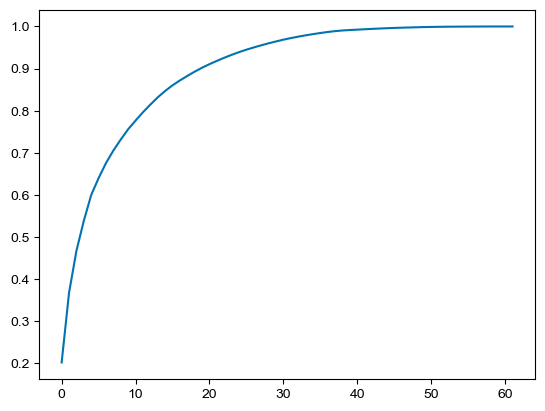

In [ ]:
pres_val = ds.df_presence[ds.species_list].values
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(pres_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


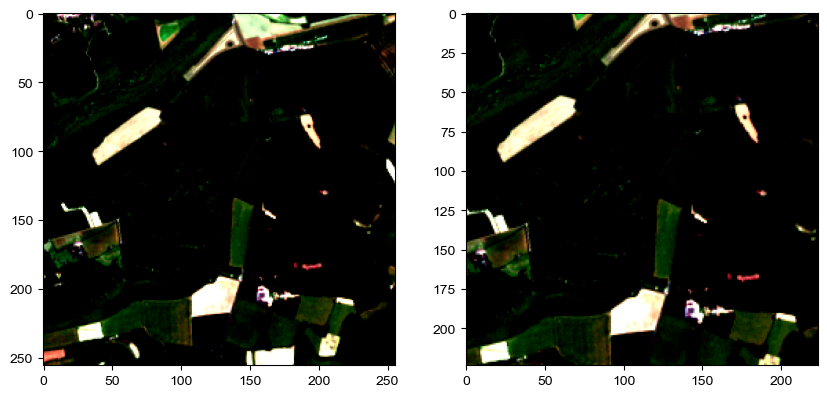

In [5]:
im, pres = ds[0]
im_transformed = ds.transform_data(im)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im[:3, :, :].permute(1, 2, 0))
ax[1].imshow(im_transformed[:3, :, :].permute(1, 2, 0))

## Results 

- v16 pred / n layers 1 
- v17 pred incl enc / n layers 2 
- v18 pecl / n layers 1 
- v19 post-pecl pred / n layers 1
- v20: pred incl enc / n_layers 2 / freeze True 
- v21: pred / n layers 2 / freeze True 
- v22: pred incl enc / n layers 2 / freeze False 

Findings:
- PECL doesn't work atm (v19 v20). Why does post-pecl pred not work though (V20)? Does passing on models in general work?
- Freezing resnet doesn't matter for pred_incl_enc (v20 v22)
- Pred incl enc works better than pred only (v22 vs v21, v17 vs v16)
- All same plateau .. Check for a trivial solution? (Different random seed.. )

 NON-weighted (B)CE:
- v114: top 20, pretrained False??, BCE, 1 layer
- v116: top 20, seco, BCE, 1 layer
- v117: top 20, seco, BCE, 2 layer
- v118: All species, Seco, BCE, 2 layer mlp pred
- v119: top 20, imagenet, BCE, 2 layer [WORSE than seco]
- v120: top 20, imagenet, BCE, 2 layer, NOT frozen [=> train loss lower but 
val loss higher] 
- v121: pecl
- v122: top 20, seco, CE, 2 layer, [converged solution much further from mean preds than with BCE (0.2 vs 0.03). BCE loss also increases. ]
- v124: top 20, seco, BCE, 2 layer, 32 enc channels [everything above 64 channels.] [Same as 64, just tiny bit slower to converge. ]
- v125: top 20, seco, BCE, 2 layer, 128 channels. [ bit quicker than 64, higher top10 acc]
- v126: top 20, seco, BCE, 2 layer, 256 channels. [again bit quicker than 128]
- v127: top 20, seco, BCE, 2 layer, 512 channels. [slightly quicker than 256/similar]
- v128: top 20, seco, CE, 2 layer, 512 channels 
- v130, top 20, seco, BCE, 2 layer, 512 channels [identical to v127] 
- v131: top 20, seco,  CE, 2 layer, 512 => also identical to CE. 

- v136: top 20, seco, weighted BCE, 2 layer, 512. [faster convergence than non-weighted BCE. ]
- v137: top 20, seco, weighted BCE, 2 layer, 256, lr 1e3
- v138: all sp, seco, weighted BCE, 2 layer, 256, 1e-3 [just ended up predicting the mean.!]
- v139: all sp, seco,  BCE, 2 layer, 246, 1e-3

In [3]:
# dict_models = {}
tmp_model, _ = pem.train_pecl(training_method='pecl', 
                    pecl_distance_metric='softmax',
                    species_process='top_20', 
                    use_class_weights=True,
                    n_enc_channels=256, lr=1e-3,
                    n_epochs_max=100, batch_size=64, 
                    pecl_knn=5, pecl_knn_hard_labels=True,
                    freeze_resnet=True, 
                    n_layers_mlp_resnet=1, n_layers_mlp_pred=2,
                    pred_train_loss='weighted-bce',
                    pretrained_resnet='seco',
                    # pretrained_resnet=False,
                    # save_model=True,
                    use_lr_scheduler=True,
                    normalise_embedding='l2')
# dict_models['bce_top20_cw'] = tmp_model

#
   

Seed set to 42


Pytorch version is 2.2.0.dev20231210
Found 1336 out of 1455 images in the image folder.
Shuffling data.
Only keeping top 20 species with most observations.
Loaded 20 class weights on cpu.
Class weights now on mps:0.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


-- Starting training at 2024-02-28 00:14:19.723165 with 100 epochs.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name             | Type       | Params
------------------------------------------------
0 | resnet           | ResNet     | 11.3 M
1 | prediction_model | Sequential | 70.9 K
------------------------------------------------
202 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.528    Total estimated model params size (MB)


Using ReduceLROnPlateau scheduler.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

tensor(0.0159, device='mps:0') tensor(0.0009, device='mps:0')
tensor(0.0160, device='mps:0') tensor(0.0008, device='mps:0')


Training: |          | 0/? [00:00<?, ?it/s]

tensor(0.0238, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0773, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0170, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0091, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0169, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0082, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0183, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0059, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0171, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0047, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0167, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0036, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0168, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0033, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0163, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0024, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0168, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0027, device='mps:0', grad_fn=<StdBackward0>)
t

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0167, device='mps:0') tensor(0.0025, device='mps:0')
tensor(0.0166, device='mps:0') tensor(0.0026, device='mps:0')
tensor(0.0164, device='mps:0') tensor(0.0020, device='mps:0')
tensor(0.0168, device='mps:0') tensor(0.0032, device='mps:0')
tensor(0.0916, device='mps:0') tensor(0.0111, device='mps:0')
tensor(0.0174, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0033, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0168, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0029, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0169, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0036, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0164, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0029, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0172, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0027, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0164, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0024, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0166, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0168, device='mps:0') tensor(0.0037, device='mps:0')
tensor(0.0172, device='mps:0') tensor(0.0040, device='mps:0')
tensor(0.0167, device='mps:0') tensor(0.0030, device='mps:0')
tensor(0.0172, device='mps:0') tensor(0.0045, device='mps:0')
tensor(0.0915, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0176, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0037, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0182, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0043, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0169, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0041, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0173, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0037, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0178, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0055, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0172, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0043, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0182, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0173, device='mps:0') tensor(0.0061, device='mps:0')
tensor(0.0184, device='mps:0') tensor(0.0067, device='mps:0')
tensor(0.0171, device='mps:0') tensor(0.0051, device='mps:0')
tensor(0.0178, device='mps:0') tensor(0.0067, device='mps:0')
tensor(0.0917, device='mps:0') tensor(0.0248, device='mps:0')
tensor(0.0187, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0068, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0175, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0054, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0193, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0078, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0199, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0085, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0189, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0058, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0185, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0060, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0186, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0175, device='mps:0') tensor(0.0063, device='mps:0')
tensor(0.0188, device='mps:0') tensor(0.0075, device='mps:0')
tensor(0.0171, device='mps:0') tensor(0.0055, device='mps:0')
tensor(0.0177, device='mps:0') tensor(0.0075, device='mps:0')
tensor(0.0912, device='mps:0') tensor(0.0264, device='mps:0')
tensor(0.0204, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0099, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0197, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0082, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0189, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0081, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0185, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0066, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0197, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0084, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0187, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0079, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0208, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0178, device='mps:0') tensor(0.0066, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0071, device='mps:0')
tensor(0.0173, device='mps:0') tensor(0.0059, device='mps:0')
tensor(0.0176, device='mps:0') tensor(0.0070, device='mps:0')
tensor(0.0919, device='mps:0') tensor(0.0253, device='mps:0')
tensor(0.0190, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0079, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0217, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0080, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0191, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0067, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0192, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0067, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0194, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0074, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0201, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0072, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0192, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0180, device='mps:0') tensor(0.0073, device='mps:0')
tensor(0.0189, device='mps:0') tensor(0.0082, device='mps:0')
tensor(0.0175, device='mps:0') tensor(0.0065, device='mps:0')
tensor(0.0181, device='mps:0') tensor(0.0076, device='mps:0')
tensor(0.0915, device='mps:0') tensor(0.0261, device='mps:0')
tensor(0.0199, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0088, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0194, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0075, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0224, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0093, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0202, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0088, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0208, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0089, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0210, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0090, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0195, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0185, device='mps:0') tensor(0.0081, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0079, device='mps:0')
tensor(0.0175, device='mps:0') tensor(0.0070, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0078, device='mps:0')
tensor(0.0915, device='mps:0') tensor(0.0290, device='mps:0')
tensor(0.0205, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0085, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0186, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0068, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0198, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0080, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0210, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0082, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0189, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0073, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0205, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0084, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0195, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0193, device='mps:0') tensor(0.0101, device='mps:0')
tensor(0.0196, device='mps:0') tensor(0.0098, device='mps:0')
tensor(0.0179, device='mps:0') tensor(0.0085, device='mps:0')
tensor(0.0184, device='mps:0') tensor(0.0093, device='mps:0')
tensor(0.0934, device='mps:0') tensor(0.0332, device='mps:0')
tensor(0.0238, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0144, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0215, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0105, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0236, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0129, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0235, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0106, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0225, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0142, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0215, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0127, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0239, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0185, device='mps:0') tensor(0.0083, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0079, device='mps:0')
tensor(0.0177, device='mps:0') tensor(0.0072, device='mps:0')
tensor(0.0180, device='mps:0') tensor(0.0076, device='mps:0')
tensor(0.0953, device='mps:0') tensor(0.0287, device='mps:0')
tensor(0.0203, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0083, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0212, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0091, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0208, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0097, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0217, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0090, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0209, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0081, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0230, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0089, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0216, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0188, device='mps:0') tensor(0.0093, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0092, device='mps:0')
tensor(0.0179, device='mps:0') tensor(0.0082, device='mps:0')
tensor(0.0178, device='mps:0') tensor(0.0084, device='mps:0')
tensor(0.0937, device='mps:0') tensor(0.0331, device='mps:0')
tensor(0.0218, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0100, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0206, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0092, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0211, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0090, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0215, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0093, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0207, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0082, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0200, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0088, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0219, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0191, device='mps:0') tensor(0.0097, device='mps:0')
tensor(0.0196, device='mps:0') tensor(0.0102, device='mps:0')
tensor(0.0182, device='mps:0') tensor(0.0086, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0090, device='mps:0')
tensor(0.0910, device='mps:0') tensor(0.0419, device='mps:0')
tensor(0.0228, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0129, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0243, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0127, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0227, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0109, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0223, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0114, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0210, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0117, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0220, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0112, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0232, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0195, device='mps:0') tensor(0.0098, device='mps:0')
tensor(0.0196, device='mps:0') tensor(0.0108, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0088, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0104, device='mps:0')
tensor(0.0923, device='mps:0') tensor(0.0444, device='mps:0')
tensor(0.0235, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0128, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0228, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0120, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0210, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0109, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0239, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0128, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0242, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0166, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0219, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0109, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0226, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0195, device='mps:0') tensor(0.0102, device='mps:0')
tensor(0.0200, device='mps:0') tensor(0.0104, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0096, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0117, device='mps:0')
tensor(0.0925, device='mps:0') tensor(0.0394, device='mps:0')
tensor(0.0209, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0097, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0224, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0099, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0207, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0092, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0218, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0100, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0215, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0091, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0215, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0085, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0197, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0199, device='mps:0') tensor(0.0119, device='mps:0')
tensor(0.0208, device='mps:0') tensor(0.0127, device='mps:0')
tensor(0.0185, device='mps:0') tensor(0.0111, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0111, device='mps:0')
tensor(0.0925, device='mps:0') tensor(0.0530, device='mps:0')
tensor(0.0256, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0161, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0249, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0133, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0219, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0131, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0229, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0169, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0220, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0118, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0250, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0138, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0232, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0200, device='mps:0') tensor(0.0111, device='mps:0')
tensor(0.0205, device='mps:0') tensor(0.0113, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0101, device='mps:0')
tensor(0.0186, device='mps:0') tensor(0.0115, device='mps:0')
tensor(0.0929, device='mps:0') tensor(0.0463, device='mps:0')
tensor(0.0228, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0130, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0245, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0118, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0248, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0120, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0247, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0139, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0244, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0122, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0222, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0115, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0242, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0199, device='mps:0') tensor(0.0116, device='mps:0')
tensor(0.0205, device='mps:0') tensor(0.0112, device='mps:0')
tensor(0.0182, device='mps:0') tensor(0.0100, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0109, device='mps:0')
tensor(0.0914, device='mps:0') tensor(0.0465, device='mps:0')
tensor(0.0234, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0163, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0229, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0115, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0238, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0113, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0230, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0107, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0236, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0116, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0255, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0147, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0237, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0199, device='mps:0') tensor(0.0120, device='mps:0')
tensor(0.0206, device='mps:0') tensor(0.0116, device='mps:0')
tensor(0.0183, device='mps:0') tensor(0.0111, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0107, device='mps:0')
tensor(0.0925, device='mps:0') tensor(0.0519, device='mps:0')
tensor(0.0235, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0132, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0247, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0133, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0241, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0139, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0248, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0138, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0138, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0255, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0145, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0193, device='mps:0') tensor(0.0093, device='mps:0')
tensor(0.0195, device='mps:0') tensor(0.0089, device='mps:0')
tensor(0.0182, device='mps:0') tensor(0.0087, device='mps:0')
tensor(0.0184, device='mps:0') tensor(0.0084, device='mps:0')
tensor(0.0933, device='mps:0') tensor(0.0452, device='mps:0')
tensor(0.0224, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0099, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0221, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0108, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0242, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0106, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0208, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0094, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0220, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0082, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0234, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0125, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0248, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0199, device='mps:0') tensor(0.0115, device='mps:0')
tensor(0.0203, device='mps:0') tensor(0.0110, device='mps:0')
tensor(0.0187, device='mps:0') tensor(0.0106, device='mps:0')
tensor(0.0188, device='mps:0') tensor(0.0103, device='mps:0')
tensor(0.0930, device='mps:0') tensor(0.0546, device='mps:0')
tensor(0.0238, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0122, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0244, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0132, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0240, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0139, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0238, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0121, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0256, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0141, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0258, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0189, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0280, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0146, device='mps:0')
tensor(0.0212, device='mps:0') tensor(0.0137, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0132, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0132, device='mps:0')
tensor(0.0930, device='mps:0') tensor(0.0654, device='mps:0')
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0171, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0268, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0200, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0201, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0248, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0169, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0294, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0177, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0275, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0189, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0261, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0146, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0131, device='mps:0')
tensor(0.0935, device='mps:0') tensor(0.0639, device='mps:0')
tensor(0.0266, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0162, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0165, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0156, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0258, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0171, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0260, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0164, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0173, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0206, device='mps:0') tensor(0.0145, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0135, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0940, device='mps:0') tensor(0.0633, device='mps:0')
tensor(0.0257, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0161, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0292, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0230, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0272, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0178, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0274, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0211, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0251, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0173, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0211, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0145, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0189, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0941, device='mps:0') tensor(0.0610, device='mps:0')
tensor(0.0257, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0153, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0281, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0203, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0212, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0271, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0260, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0156, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0264, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0167, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0250, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0206, device='mps:0') tensor(0.0142, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0136, device='mps:0')
tensor(0.0189, device='mps:0') tensor(0.0127, device='mps:0')
tensor(0.0189, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0942, device='mps:0') tensor(0.0604, device='mps:0')
tensor(0.0232, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0177, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0261, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0167, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0289, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0154, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0254, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0147, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0252, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0167, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0273, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0267, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0205, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0211, device='mps:0') tensor(0.0132, device='mps:0')
tensor(0.0189, device='mps:0') tensor(0.0123, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0129, device='mps:0')
tensor(0.0942, device='mps:0') tensor(0.0576, device='mps:0')
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0190, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0172, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0289, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0248, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0157, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0192, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0251, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0143, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0282, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0206, device='mps:0') tensor(0.0146, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0132, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0949, device='mps:0') tensor(0.0609, device='mps:0')
tensor(0.0304, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0185, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0264, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0306, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0210, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0181, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0264, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0194, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0271, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0209, device='mps:0') tensor(0.0156, device='mps:0')
tensor(0.0215, device='mps:0') tensor(0.0147, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0193, device='mps:0') tensor(0.0152, device='mps:0')
tensor(0.0950, device='mps:0') tensor(0.0626, device='mps:0')
tensor(0.0255, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0176, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0268, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0184, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0271, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0177, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0177, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0267, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0186, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0285, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0209, device='mps:0') tensor(0.0152, device='mps:0')
tensor(0.0212, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0143, device='mps:0')
tensor(0.0950, device='mps:0') tensor(0.0598, device='mps:0')
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0243, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0267, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0215, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0178, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0277, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0206, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0157, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0282, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0196, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0282, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0207, device='mps:0') tensor(0.0150, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0952, device='mps:0') tensor(0.0594, device='mps:0')
tensor(0.0268, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0163, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0288, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0252, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0246, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0172, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0262, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0150, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0265, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0273, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0136, device='mps:0')
tensor(0.0953, device='mps:0') tensor(0.0593, device='mps:0')
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0187, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0289, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0298, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0277, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0181, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0159, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0272, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0187, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0293, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0212, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0955, device='mps:0') tensor(0.0604, device='mps:0')
tensor(0.0250, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0183, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0265, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0186, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0261, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0156, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0252, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0137, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0172, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0286, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0198, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0269, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0207, device='mps:0') tensor(0.0150, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0137, device='mps:0')
tensor(0.0953, device='mps:0') tensor(0.0590, device='mps:0')
tensor(0.0261, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0173, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0275, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0279, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0191, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0195, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0249, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0139, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0261, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0166, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0246, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0136, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0955, device='mps:0') tensor(0.0598, device='mps:0')
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0179, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0295, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0189, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0277, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0192, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0279, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0193, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0205, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0175, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0251, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0150, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0955, device='mps:0') tensor(0.0587, device='mps:0')
tensor(0.0269, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0187, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0257, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0162, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0266, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0156, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0297, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0212, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0287, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0186, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0251, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0306, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0957, device='mps:0') tensor(0.0594, device='mps:0')
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0194, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0279, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0162, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0245, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0170, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0289, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0195, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0243, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0130, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0271, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0166, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0279, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0209, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0140, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0136, device='mps:0')
tensor(0.0957, device='mps:0') tensor(0.0597, device='mps:0')
tensor(0.0276, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0179, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0288, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0208, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0270, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0163, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0285, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0187, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0259, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0180, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0308, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0197, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0305, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0208, device='mps:0') tensor(0.0151, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0957, device='mps:0') tensor(0.0597, device='mps:0')
tensor(0.0280, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0189, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0268, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0174, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0264, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0159, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0290, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0189, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0278, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0220, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0258, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0172, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0266, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0206, device='mps:0') tensor(0.0149, device='mps:0')
tensor(0.0213, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0132, device='mps:0')
tensor(0.0190, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0951, device='mps:0') tensor(0.0599, device='mps:0')
tensor(0.0260, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0153, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0229, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0181, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0161, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0251, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0191, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0183, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0263, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0209, device='mps:0') tensor(0.0154, device='mps:0')
tensor(0.0214, device='mps:0') tensor(0.0142, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0135, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0138, device='mps:0')
tensor(0.0953, device='mps:0') tensor(0.0603, device='mps:0')
tensor(0.0264, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0194, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0290, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0193, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0253, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0162, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0298, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0200, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0284, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0185, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0270, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0155, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0256, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0209, device='mps:0') tensor(0.0153, device='mps:0')
tensor(0.0214, device='mps:0') tensor(0.0142, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0134, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0139, device='mps:0')
tensor(0.0954, device='mps:0') tensor(0.0601, device='mps:0')
tensor(0.0293, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0208, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0306, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0209, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0252, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0166, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0283, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0162, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0254, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0181, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0279, device='mps:0', grad_fn=<MeanBackward0>) tensor(0.0194, device='mps:0', grad_fn=<StdBackward0>)
tensor(0.0273, device='m

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.0210, device='mps:0') tensor(0.0153, device='mps:0')
tensor(0.0214, device='mps:0') tensor(0.0141, device='mps:0')
tensor(0.0191, device='mps:0') tensor(0.0133, device='mps:0')
tensor(0.0192, device='mps:0') tensor(0.0135, device='mps:0')
tensor(0.0954, device='mps:0') tensor(0.0600, device='mps:0')
-- Finished training at 2024-02-28 00:31:29.051649.
Stats saved as PECL-ImEn_2024-02-28-0031_vnum-145_stats.pkl at /Users/t.vanderplas/models/PECL/stats/PECL-ImEn_2024-02-28-0031_vnum-145_stats.pkl


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [231]:
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')


Loaded ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [6]:
tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
                             pecl_distance_metric='softmax',
                             training_method='pecl',
                             pretrained_resnet='seco')

No class weights.
Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# tmp = tmp_model.pecl_pass(batch)
# tmp[0], tmp[1].shape    

# (pem.normalised_softmax_distance_batch(im_enc) > 0).all()

tensor(True)

In [78]:
# train_dl, val_dl = _
val_dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)


for i_batch, batch in enumerate(val_dl):
    im, label = batch 
    im = im.to(tmp_model.device)
    print(im.shape[0])
    im_enc = tmp_model.forward(im)
    pred = tmp_model.prediction_model(im_enc)
    assert pred.shape == label.shape, f'pred.shape={pred.shape}, label.shape={label.shape}'
    if i_batch == 1:
        break

32
32


Text(0.5, 25.52222222222222, 'embedding dimension')

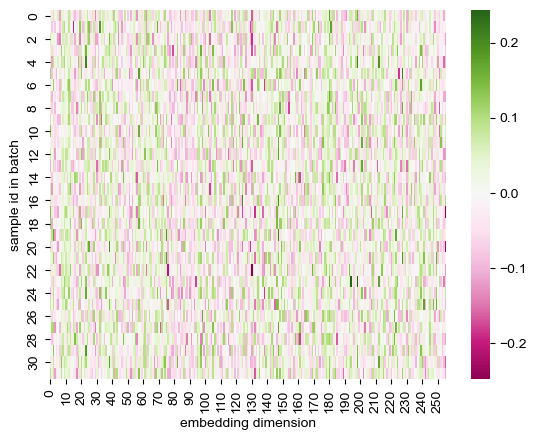

In [73]:
import seaborn as sns
sns.heatmap(im_enc.cpu().detach().numpy(), cmap='PiYG')    
plt.ylabel('sample id in batch')
plt.xlabel('embedding dimension')

(32, 62)
(32, 62) (32,)


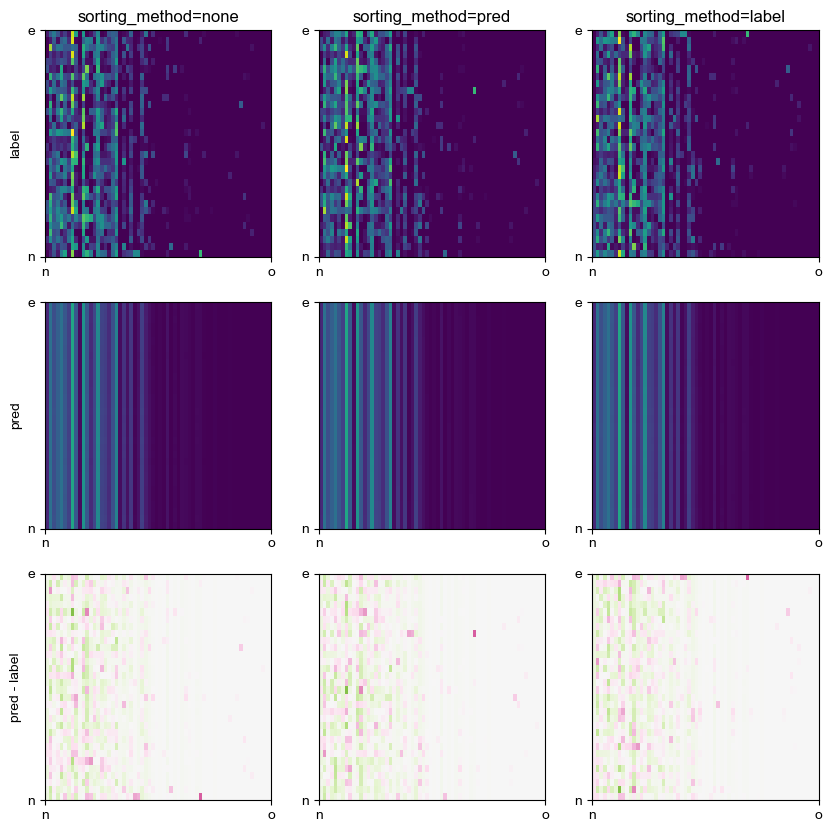

In [79]:
if type(pred) == torch.Tensor:
    if pred.device != 'cpu':
        pred = pred.cpu()
    pred = pred.detach().numpy()
if type(label) == torch.Tensor:
    if label.device != 'cpu':
        label = label.cpu()
    label = label.detach().numpy()
pred_zero_mean = pred - pred.mean(0)
label_zero_mean = label - label.mean(0)

assert pred.max() <= 1, f'pred.max()={pred.max()}'
assert pred.min() >= 0, f'pred.min()={pred.min()}'
assert label.max() <= 1, f'label.max()={label.max()}'
assert label.min() >= 0, f'label.min()={label.min()}'

# accuracy = 

print(label.shape)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for col, sorting_method in enumerate(['none', 'pred', 'label']):
    if sorting_method == 'none':
        idx = np.arange(label.shape[0])
    elif sorting_method == 'pred':
        idx = np.argsort(pred.sum(1))
    elif sorting_method == 'label':
        idx = np.argsort(label[:, 0])
        print(label.shape, idx.shape)
    
    ax[0, col].imshow(label[idx, :], vmin=0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[1, col].imshow(pred[idx, :], vmin=-0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[2, col].imshow(pred[idx, :] - label[idx, :], vmin=-1, vmax=1, cmap='PiYG', extent='none', interpolation='none')
    ax[0, col].set_title(f'sorting_method={sorting_method}')
    if col == 0:
        ax[0, col].set_ylabel('label')
        ax[1, col].set_ylabel('pred')
        ax[2, col].set_ylabel('pred - label')

In [80]:
np.mean(np.abs(pred - label)), np.mean(np.abs(label.mean(0)[None, :] - label))



(0.057820775, 0.054450847)

Text(0, 0.5, 'Predicted label')

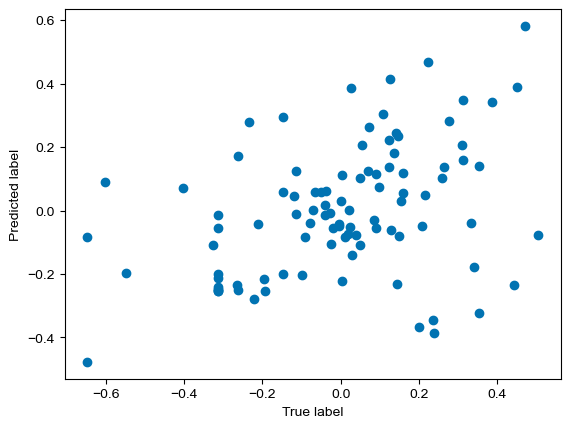

In [ ]:
i_sample = 0
plt.scatter(label_zero_mean[:, :].ravel(), pred_zero_mean[:, :].ravel())
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [ ]:
# tmp_model = dict_models['pred_pca']
# tmp_model = im_enc
# tmp_model = pem.ImageEncoder.load_from_checkpoint("/Users/t.vanderplas/models/PECL/lightning_logs/version_2/checkpoints/best_checkpoint_val-epoch=45-val_loss=0.28-train_loss=0.15.ckpt")
# print(model.learning_rate)
tmp_model.eval()
single_data_sample = ds[0][0]
multi_data_sample = [ds[ii][0] for ii in range(10)]
multi_data_sample = torch.stack(multi_data_sample)
multi_label_sample = torch.stack([ds[ii][1] for ii in range(10)])
pred_enc = tmp_model.forward(multi_data_sample)
pred_pres = tmp_model.prediction_model(pred_enc)

print(pred_enc.shape, pred_pres.shape, multi_label_sample.shape)
tmp_model.top_k_accuracy(preds=pred_pres, target=multi_label_sample, k=20)

torch.Size([10, 32]) torch.Size([10, 20]) torch.Size([10, 20])


tensor(1.)

torch.Size([10, 32])


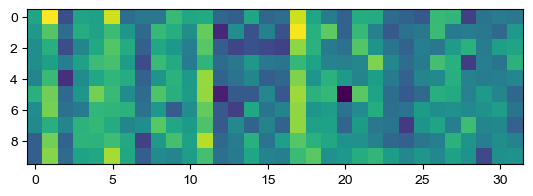

In [ ]:
tmp_pred = tmp_model.resnet(multi_data_sample)
print(tmp_pred.shape)
plt.imshow(tmp_pred.detach().numpy())
# torch.nn.functional.normalize(tmp_pred, p=1, dim=1).abs().sum(1)

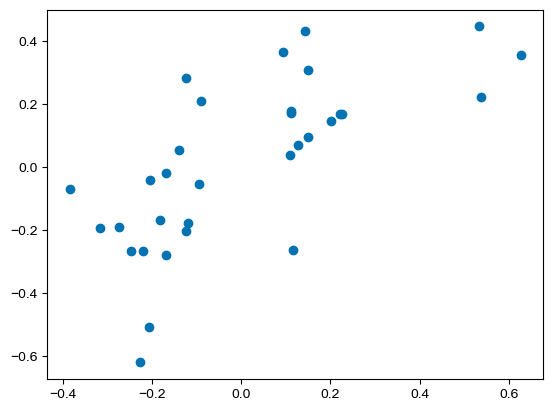

In [ ]:
plt.scatter(tmp_pred[0, :].detach().numpy(), tmp_pred[5, :].detach().numpy())

In [ ]:

target = torch.tensor([[.3, .1, .2, .1],[.1, 1, .3, .5]])
preds = torch.tensor([[0.1, 0.9, 0, 0], [0.2, 0.1, 0.5, 0.2]])
assert preds.shape[0] == target.shape[0], f'preds.shape[0] = {preds.shape[0]} != target.shape[0] = {target.shape[0]}'

loss_fn = torch.nn.BCELoss(reduction='none')
intermediate_loss = loss_fn(preds, target)
weights = torch.tensor([3.1, .2, 1.3, .4])
# print(intermediate_loss)
print(intermediate_loss)
final_loss = (intermediate_loss * weights)
final_loss.mean()

tensor([[ 0.7645,  2.0829, 20.0000, 10.0000],
        [ 0.3618,  2.3026,  0.6931,  0.9163]])


tensor(4.4545)

In [ ]:
n_samples = 6
n_classes = 5
## create two random torch matrices
# matrix 1
matrix1 = np.random.rand(n_samples, n_classes)
# matrix 2
matrix2 = np.random.rand(n_samples, n_classes)
matrix1 = torch.tensor(matrix1).float()
matrix2 = torch.tensor(matrix2).float()
assert matrix1.ndim == 2
tmp = torch.mm(matrix1, matrix1.t())

print(tmp.sum(0), tmp.sum(1))

tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796]) tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796])


In [ ]:
dist1 = pem.normalised_softmax_distance_batch(matrix1, exclude_diag_in_denominator=False, flatten=True)
dist2 = pem.normalised_softmax_distance_batch(matrix2, exclude_diag_in_denominator=False, flatten=True)

torch.Size([2, 15]) torch.Size([6, 6])
torch.Size([2, 15]) torch.Size([6, 6])


## Look at PECL pass
Look at:
- Distribution of s_ij values
- Distribution of w_ij values
- Steps of PECL pass

In [166]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='top_20',
                              zscore_im=True, 
                              augment_image=False, mode='val')
from torch.utils.data import DataLoader
train_dl = DataLoader(ds, batch_size=64, shuffle=False)

tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
                             pecl_distance_metric='softmax',
                             training_method='pecl',
                             pretrained_resnet='seco')

tmp_model.eval() 


Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping top 20 species with most observations.
No class weights.
Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [236]:
with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(train_dl)):
        im, label = batch 
        
        im = im.to(tmp_model.device)
        im_enc = tmp_model.forward(im)
        pred = tmp_model.prediction_model(im_enc)
        
        if i_batch == 0:
            all_labels = label.clone() 
            all_im_encs = im_enc.clone()
            all_preds = pred.clone()
        else:
            all_labels = torch.cat([all_labels, label], dim=0)
            all_im_encs = torch.cat([all_im_encs, im_enc], dim=0)
            all_preds = torch.cat([all_preds, pred], dim=0)
        
        if i_batch == 1:
            break

1it [00:12, 12.33s/it]


In [237]:
import torch.nn.functional as F
all_labels_norm = F.normalize(all_labels, p=2, dim=1)
all_preds_norm = F.normalize(all_preds, p=2, dim=1)

In [261]:
temperature = 0.1

all_labels_sm = pem.normalised_softmax_distance_batch(all_labels_norm, temperature=temperature, knn=5,
                                                      knn_hard_labels=True, 
                                                      exclude_diag_in_denominator=False, flatten=False)

all_im_encs_sm = pem.normalised_softmax_distance_batch(all_im_encs, temperature=temperature, knn=None,
                                                        exclude_diag_in_denominator=False, flatten=False)


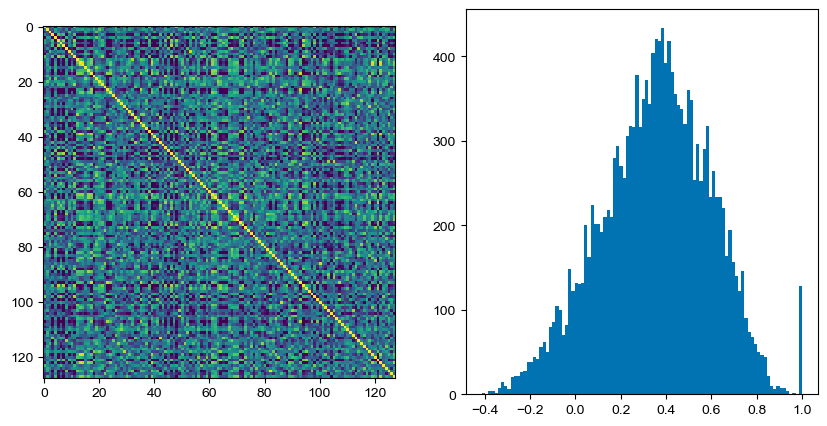

In [263]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(all_im_encs_sm.cpu().detach().numpy(), vmin=0, vmax=1, interpolation='none')
ax[1].hist(all_im_encs_sm.cpu().detach().numpy().ravel(), bins=100);

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))


# ax[0].hist(all_labels_sm, bins=100)
# ax[0].set_title('all_labels_sm')

# ax[1].hist(all_im_encs_sm, bins=100)
# ax[1].set_title('all_im_encs_sm')

# # ax[2].scatter(all_labels_sm, all_im_encs_sm)
# # ax[2].set_xlabel('all_labels_sm')
# # ax[2].set_ylabel('all_im_encs_sm')

In [190]:
# all_labels_norm_demeaned = all_labels_norm - all_labels_norm.mean(0)
# inner_prod_labels = torch.mm(all_labels_norm_demeaned, all_labels_norm_demeaned.t())
inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
## set diag to 0
inner_prod_labels = inner_prod_labels - torch.diag(inner_prod_labels.diag())

Got 127 nearest neighbours
[0.983 0.97  0.968 0.958 0.944]


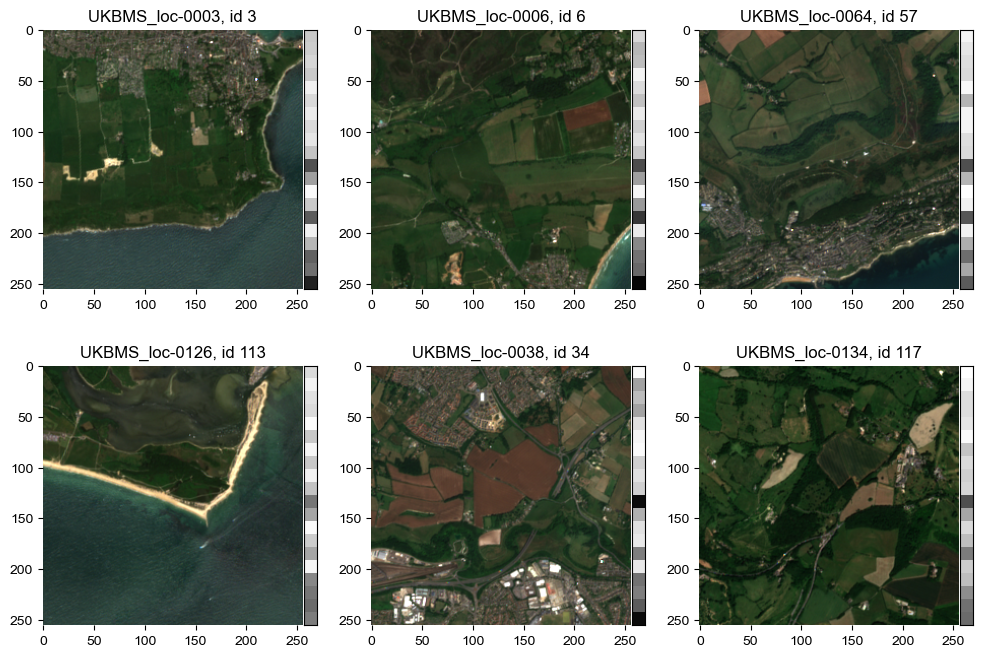

In [191]:

focal_ind = 3

## Using PECL Knn:
# inds_nz = torch.where(all_labels_sm > 0)
# inds_nn = inds_nz[1][inds_nz[0] == focal_ind]
# assert len(inds_nn) == 5, f'len(inds_nn)={len(inds_nn)}'

## Using inner product:
inds_nn = torch.where(inner_prod_labels[focal_ind, :] > 0.15)[0]
print(f'Got {len(inds_nn)} nearest neighbours')
## sort:
inds_nn = inds_nn[torch.argsort(inner_prod_labels[focal_ind, inds_nn], descending=True)]

inds_plot = [focal_ind] + inds_nn.tolist()
inds_plot = inds_plot[:6]
vals_inner = inner_prod_labels[focal_ind, inds_plot[1:]]
## round decimals:
vals_inner = np.round(vals_inner.numpy(), 3)
print(vals_inner)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel()

for i_ind, ind in enumerate(inds_plot):
    ds.plot_image(ind, ax=ax[i_ind])

(array([2.743e+03, 3.573e+03, 2.945e+03, 2.490e+03, 1.895e+03, 1.362e+03,
        7.740e+02, 3.770e+02, 1.280e+02, 5.500e+01, 1.900e+01, 1.100e+01,
        8.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
        0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
        0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
        0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
 <BarContainer object of 19 artists>)

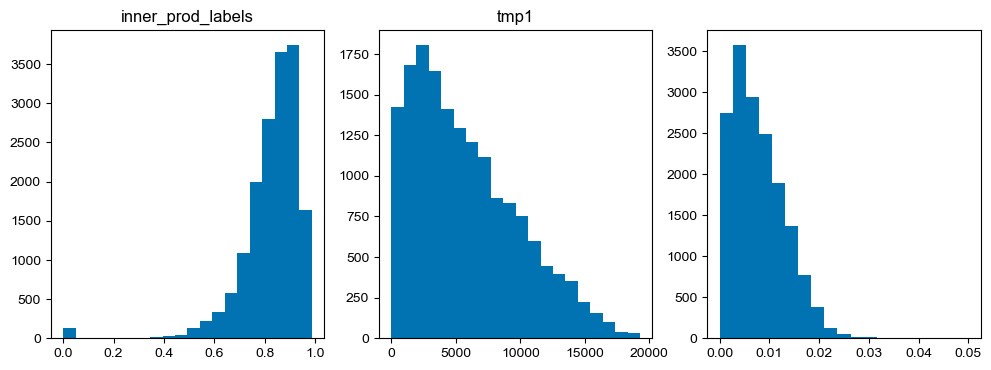

In [192]:
# inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
tmp1 = inner_prod_labels / 0.1 
tmp1 = torch.exp(tmp1)
tmp2 = torch.sum(tmp1, dim=1) - torch.diag(tmp1)
tmp3 = tmp1 / tmp2[:, None]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(inner_prod_labels.numpy().ravel(), bins=20)
ax[0].set_title('inner_prod_labels')

ax[1].hist(tmp1.numpy().ravel(), bins=20)
ax[1].set_title('tmp1')

ax[2].hist(tmp3.numpy().ravel(), bins=np.linspace(0, 0.05, 20))


In [213]:
tmp_model.pecl_knn = None

In [270]:
tmp_ims, tmp_preds = tmp_model.pecl_loss(im_enc=all_im_encs[:64, :], pres_vec=all_labels[:64, :])

In [271]:
tmp_inds = torch.where(tmp_preds > 0)

In [287]:
# tmp_ims = tmp_ims[tmp_inds]
(-1 * torch.log(tmp_ims) * tmp_preds[tmp_inds]).mean()

tensor(5.7158)

In [285]:
import torch.nn as nn 
nn.CrossEntropyLoss(reduction='none')(tmp_ims, tmp_preds[tmp_inds])

tensor(1846.0205)